In [2]:
#create reference for CSV file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%pip install scipy
from scipy.stats import zscore
import seaborn as sns


Note: you may need to restart the kernel to use updated packages.


Objective
The goal is to investigate whether or not there is a "home field advantage" for a nation that hosts the Olympic games. This analysis will study the Chinese olympic team, and try to determine if there was an unusually high improvement in performance during the 2008 Summer Olympic Games in Beijing.

Metrics to Produce
We will look at the following metrics in order to check for a host advantage, considering medal count as the measure for success in an Olympic Games:

Medal count trends:
Did the total medal count increase during the hosted olympics?
How many standard deviations (z-score) from the average medal count across all olympic games was the medal count for the hosted games?
Where did the host country place on the total medal rankings in their hosted games vs. other games?
How did the host country's performance metrics compare to the rest of the world's metrics? Does that tell us anything?

In [3]:
#read CSV file into a dataframe
olympics_path = "resources/athlete_events.csv"

olympics_df = pd.read_csv(olympics_path, low_memory = False)

#print the first 5 rows
olympics_df.head(5)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [4]:
# use only the Summer Olympics for Analysis
summer_df = olympics_df[olympics_df['Season'] == 'Summer']

In [5]:
#Create variables for the specific host country
host_country = 'Great Britain'
host_NOC = 'GBR'
host_year = '2012'

In [6]:
# create a dataframe for only the UK team, where "Great Britain" is anywhere in the team name
host_df = summer_df[summer_df['Team'].str.contains(host_country, case=False)]
# print the unique values of Team column to see if they are all "China"
print(host_df['Team'].unique())
print(host_df['NOC'].unique())
# Clean up the Team column to have only "Great Britain" instead of "Great Britain-1", "Great Britain-2", etc.
host_df.loc[:, 'Team'] = host_country
print(host_df['Team'].unique())

# It looks like NOC is a more accurate way to describe the country's team,
# and doesn't pose as many issues as the Team column does (e.g. "China-1", "China-2", etc.)
# Let's use NOC instead of Team for the rest of the analysis.

['Great Britain' 'Great Britain-1' 'Great Britain-2' 'Great Britain-3'
 'Great Britain/Germany' 'Great Britain-4' 'United States/Great Britain'
 'Australia/Great Britain' 'France/Great Britain' 'Bohemia/Great Britain']
['GBR' 'AUS' 'USA' 'FRA' 'BOH' 'GER']
['Great Britain']


In [7]:
# create a dataframe where NOC is not CHN
rest_of_world_df = summer_df[summer_df['NOC'] != 'GBR']

# Clean up the team names to have only the country name
# if "-" appears in the team name, use only the part of the string that comes before "-"
rest_of_world_df.loc[:, 'Team'] = rest_of_world_df['Team'].str.split('-').str[0]

In [8]:
# create a dataframe that is the rest_of_world_df (referred to now as rw) grouped by Games, then NOC
# We can use this to calculate medal counts for each country in each Games
games_df_rw = rest_of_world_df.groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()

# Add columns for gold_medals, silver_medals, bronze_medals and total_medals
# This will be, for each NOC, the sum of the medals won in each category for each games
games_df_rw['gold_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Gold'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']
games_df_rw['silver_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Silver'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']
games_df_rw['bronze_medals'] = rest_of_world_df[rest_of_world_df['Medal'] == 'Bronze'].groupby(['Games', 'NOC']).agg({'Medal': 'count'}).reset_index()['Medal']
# create a clean column for total medals
games_df_rw['total_medals'] = games_df_rw['Medal'] + games_df_rw['gold_medals'] + games_df_rw['silver_medals'] + games_df_rw['bronze_medals']
# fill NaN values with 0
games_df_rw = games_df_rw.fillna(0)

# format values in all columns except Games to integers
games_df_rw = games_df_rw.astype({'Medal': 'int', 'gold_medals': 'int', 'silver_medals': 'int', 'bronze_medals': 'int'})

games_df_rw

,Games,NOC,Medal,gold_medals,silver_medals,bronze_medals,total_medals
0,1896 Summer,AUS,3,2,1,1,7.0
1,1896 Summer,AUT,5,2,2,2,11.0
2,1896 Summer,DEN,6,1,4,3,14.0
3,1896 Summer,FRA,11,5,5,2,23.0
4,1896 Summer,GER,32,25,18,2,77.0
...,...,...,...,...,...,...,...
2776,2016 Summer,VIE,2,0,0,0,0.0
2777,2016 Summer,VIN,0,0,0,0,0.0
2778,2016 Summer,YEM,0,0,0,0,0.0
2779,2016 Summer,ZAM,0,0,0,0,0.0


In [9]:
# create a dataframe for the English team in the Summer Olympics grouped by Games.
games_df_gb = host_df.groupby('Games').agg({'Medal': 'count'})

# Add columns for gold_medals, silver_medals, bronze_medals and total_medals
games_df_gb['gold_medals'] = host_df[host_df['Medal'] == 'Gold'].groupby('Games').agg({'Medal': ['count']})
games_df_gb['silver_medals'] = host_df[host_df['Medal'] == 'Silver'].groupby('Games').agg({'Medal': ['count']})
games_df_gb['bronze_medals'] = host_df[host_df['Medal'] == 'Bronze'].groupby('Games').agg({'Medal': ['count']})

# fill NaN values with 0
games_df_gb = games_df_gb.fillna(0)

# format values in all columns except Games to integers
games_df_gb = games_df_gb.astype(int)

games_df_gb

,Medal,gold_medals,silver_medals,bronze_medals
Games,,,,
1896 Summer,11,4,3,4
1900 Summer,32,11,8,13
1904 Summer,2,1,1,0
1906 Summer,31,9,14,8
1908 Summer,199,81,72,46
1912 Summer,134,38,37,59
1920 Summer,107,48,42,17
1924 Summer,59,15,25,19
1928 Summer,58,7,27,24


In [10]:
# create a cleaner "total_medals" column
games_df_gb['total_medals'] = games_df_gb[['gold_medals', 'silver_medals', 'bronze_medals']].sum(axis=1)

# Add a column for non-medal participations, which is the count of all rows for Games where Medal is NaN
games_df_gb['non_medal_participations'] = host_df[host_df['Medal'].isnull()].groupby('Games').size()

# Add a column for total participations, which is the count of all rows for Games.
# This includes 0 or NaN values for medals
games_df_gb['total_participations'] = host_df.groupby('Games').size()
games_df_gb

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations
Games,,,,,,,
1896 Summer,11,4,3,4,11,16,27
1900 Summer,32,11,8,13,32,34,66
1904 Summer,2,1,1,0,2,4,6
1906 Summer,31,9,14,8,31,73,104
1908 Summer,199,81,72,46,199,591,790
1912 Summer,134,38,37,59,134,252,386
1920 Summer,107,48,42,17,107,232,339
1924 Summer,59,15,25,19,59,364,423
1928 Summer,58,7,27,24,58,290,348


In [32]:
# Create a column called 'medal_rate' which is the ratio of medal count to total participation count
games_df_gb['medal_rate'] = games_df_gb['total_medals'] / games_df_gb['total_participations']*100
games_df_gb

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage
Games,,,,,,,,,,,,
1896 Summer,11,4,3,4,11,16,27,40.740741,36.363636,27.272727,36.363636,59.259259
1900 Summer,32,11,8,13,32,34,66,48.484848,34.375000,25.000000,40.625000,51.515152
1904 Summer,2,1,1,0,2,4,6,33.333333,50.000000,50.000000,0.000000,66.666667
1906 Summer,31,9,14,8,31,73,104,29.807692,29.032258,45.161290,25.806452,70.192308
1908 Summer,199,81,72,46,199,591,790,25.189873,40.703518,36.180905,23.115578,74.810127
1912 Summer,134,38,37,59,134,252,386,34.715026,28.358209,27.611940,44.029851,65.284974
1920 Summer,107,48,42,17,107,232,339,31.563422,44.859813,39.252336,15.887850,68.436578
1924 Summer,59,15,25,19,59,364,423,13.947991,25.423729,42.372881,32.203390,86.052009
1928 Summer,58,7,27,24,58,290,348,16.666667,12.068966,46.551724,41.379310,83.333333


In [33]:
# create columns called gold_percentage, silver_percentage, bronze_percentage and non_medal_percentage
games_df_gb['gold_percentage'] = games_df_gb['gold_medals'] / games_df_gb['total_medals']*100
games_df_gb['silver_percentage'] = games_df_gb['silver_medals'] / games_df_gb['total_medals']*100
games_df_gb['bronze_percentage'] = games_df_gb['bronze_medals'] / games_df_gb['total_medals']*100
games_df_gb['non_medal_percentage'] = games_df_gb['non_medal_participations'] / games_df_gb['total_participations']*100

games_df_gb

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage
Games,,,,,,,,,,,,
1896 Summer,11,4,3,4,11,16,27,40.740741,36.363636,27.272727,36.363636,59.259259
1900 Summer,32,11,8,13,32,34,66,48.484848,34.375000,25.000000,40.625000,51.515152
1904 Summer,2,1,1,0,2,4,6,33.333333,50.000000,50.000000,0.000000,66.666667
1906 Summer,31,9,14,8,31,73,104,29.807692,29.032258,45.161290,25.806452,70.192308
1908 Summer,199,81,72,46,199,591,790,25.189873,40.703518,36.180905,23.115578,74.810127
1912 Summer,134,38,37,59,134,252,386,34.715026,28.358209,27.611940,44.029851,65.284974
1920 Summer,107,48,42,17,107,232,339,31.563422,44.859813,39.252336,15.887850,68.436578
1924 Summer,59,15,25,19,59,364,423,13.947991,25.423729,42.372881,32.203390,86.052009
1928 Summer,58,7,27,24,58,290,348,16.666667,12.068966,46.551724,41.379310,83.333333


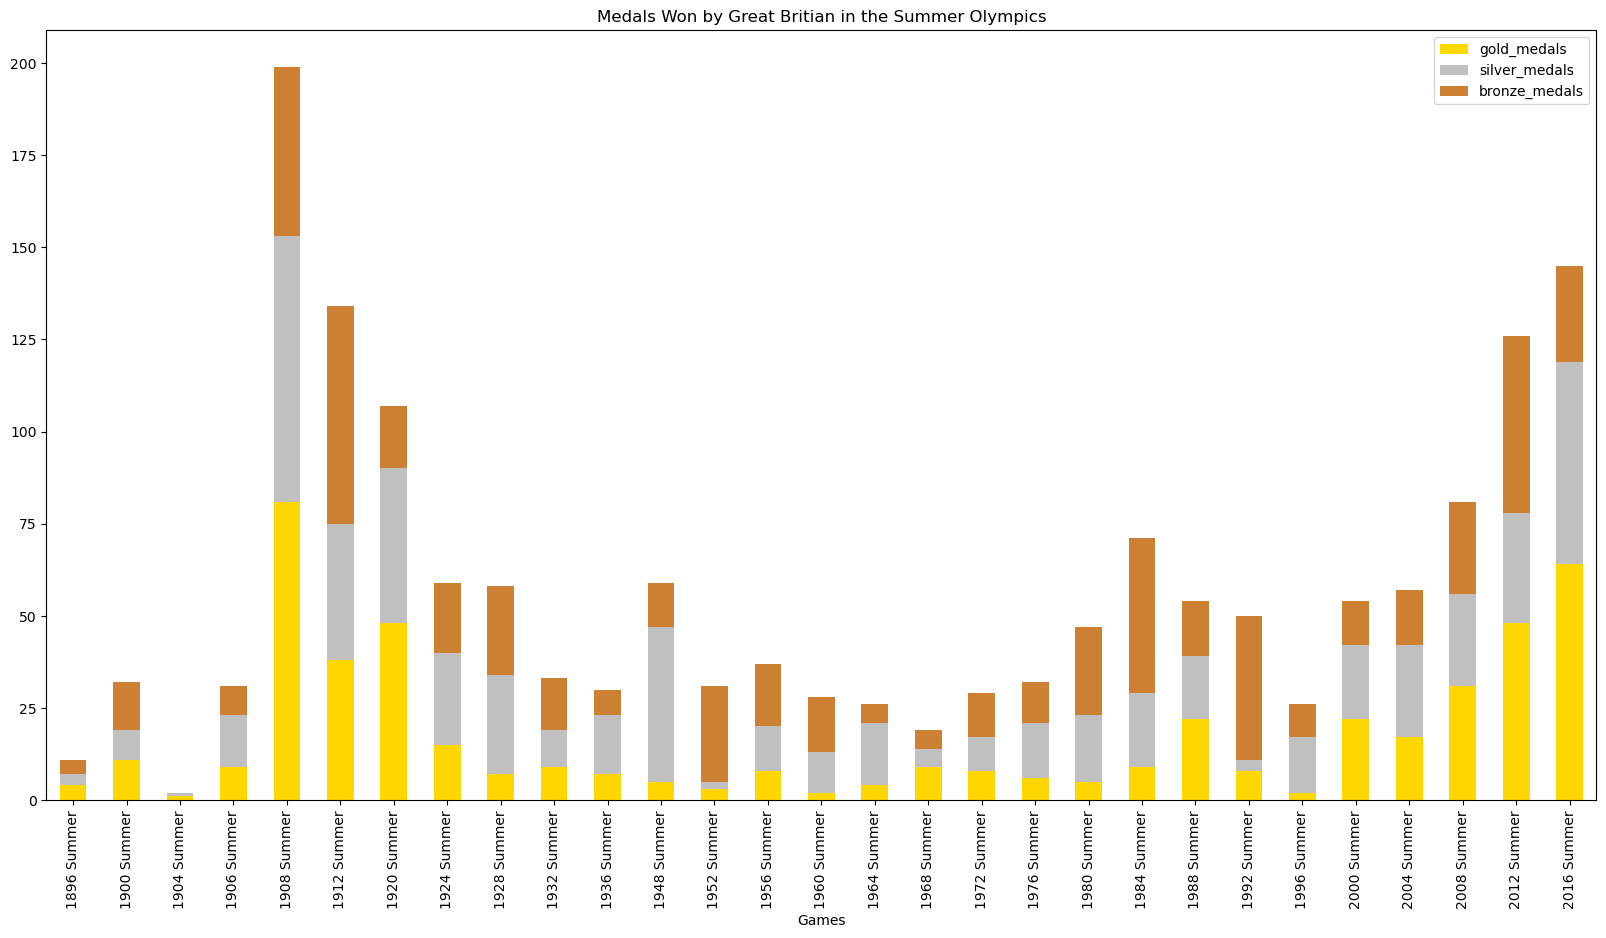

In [13]:
# Plot the gold_medals, silver_medals, bronze_medals and non_medal_participations for the Chinese team in the Summer Olympics.
# Use a stacked bar chart, where the total size of the bar is the total_participations
games_df_gb[['gold_medals', 'silver_medals', 'bronze_medals']].plot(
                                    kind='bar',
                                    stacked=True,
                                    figsize=(20, 10),
                                    color=['#ffd700', '#c0c0c0', '#cd7f32'],
                                    title='Medals Won by Great Britian in the Summer Olympics',)
# use #ffd700 for gold, #c0c0c0 for silver and #cd7f32 for bronze

#Save Image for Use in Slides
plt.savefig('resources/medals_won_gb.png')

/opt/anaconda3/envs/dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/dev/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


(<Axes: title={'center': 'Medals Won by Great Britain in the Summer Olympics'}, xlabel='Games'>,
 Text(0.5, 1.0, 'Medals Won by Great Britain in the Summer Olympics'))

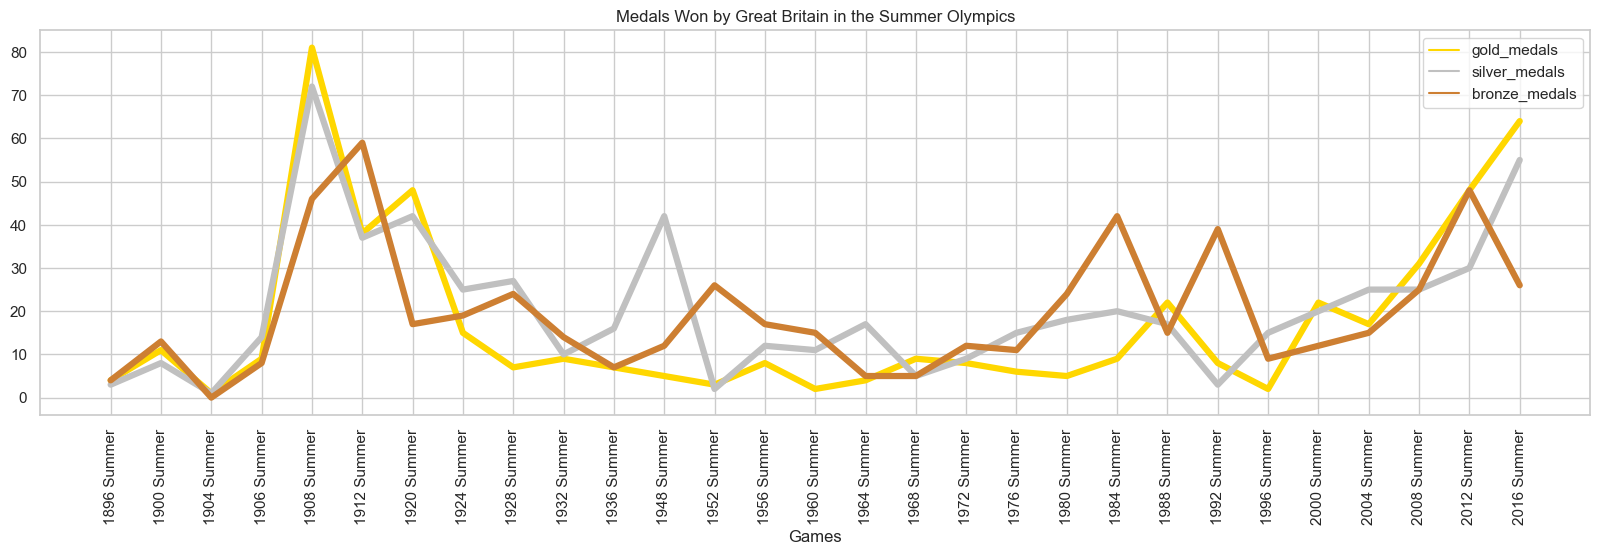

In [30]:
#Create a different visualization for the same data
sns.set_theme(style="whitegrid")

# use #ffd700 for gold, #c0c0c0 for silver and #cd7f32 for bronze
plt.figure(figsize=(20, 5))
plt.xticks(rotation='vertical')
data = games_df_gb[['gold_medals', 'silver_medals', 'bronze_medals']]
palette = {'gold_medals': '#ffd700', 'silver_medals': '#c0c0c0', 'bronze_medals': '#cd7f32'}
sns.lineplot(data=data, palette=palette, linewidth=4.5, dashes=False), plt.title('Medals Won by Great Britain in the Summer Olympics')


<Axes: title={'center': 'Medal Rate for China in the Summer Olympics'}, xlabel='Games'>

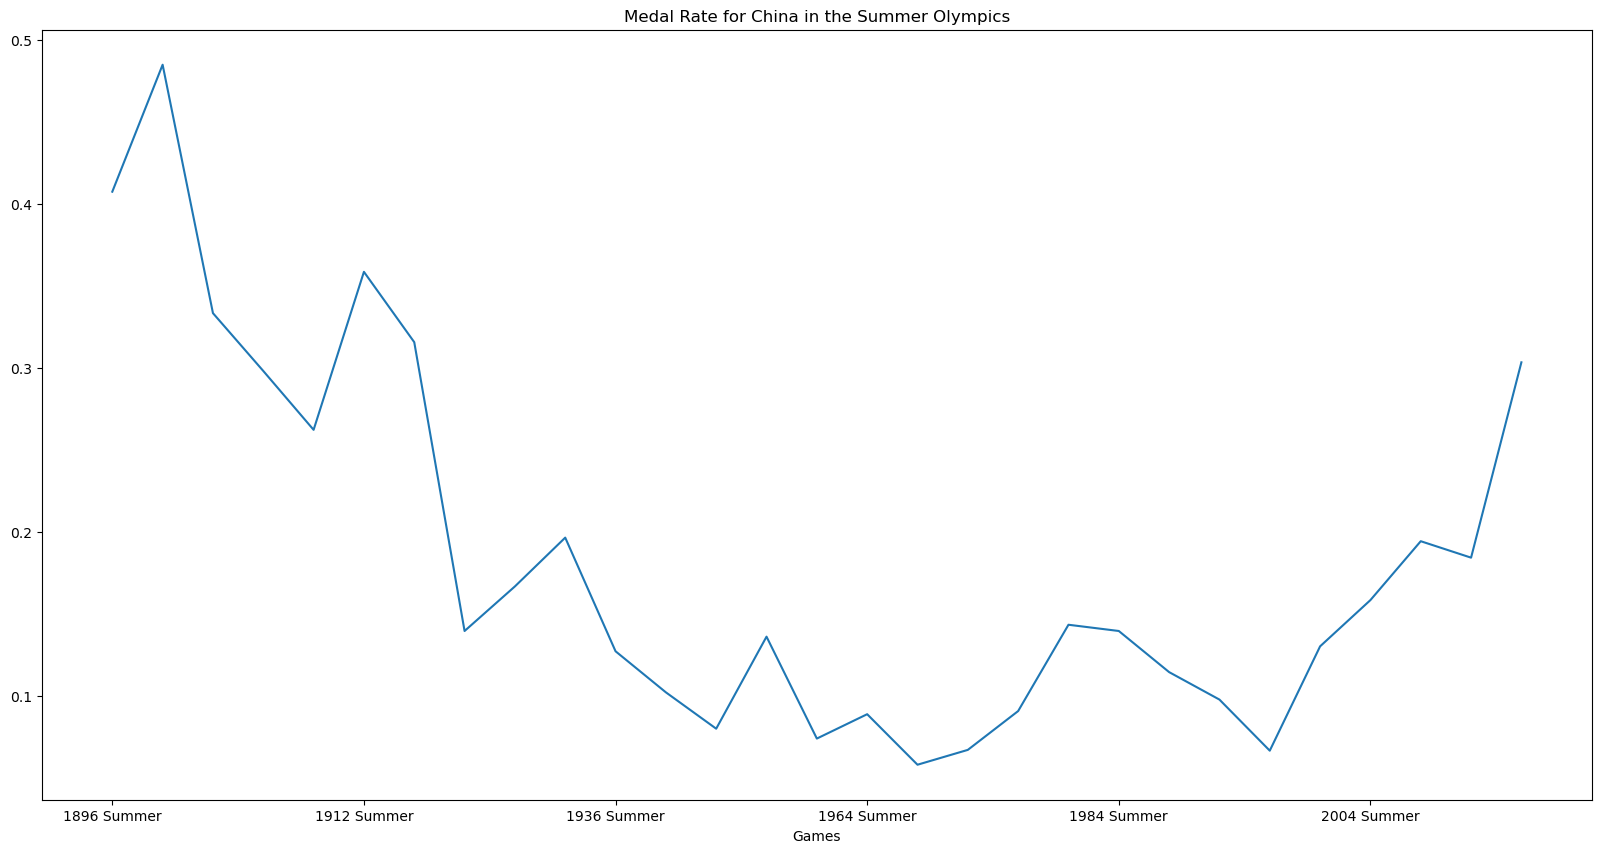

In [12]:
# Use a line chart to plot the medal_rate for the English team in the Summer Olympics.
games_df_gb['medal_rate'].plot(kind='line', figsize=(20, 10), title='Medal Rate for Great Britain in the Summer Olympics')

<Axes: xlabel='Games'>

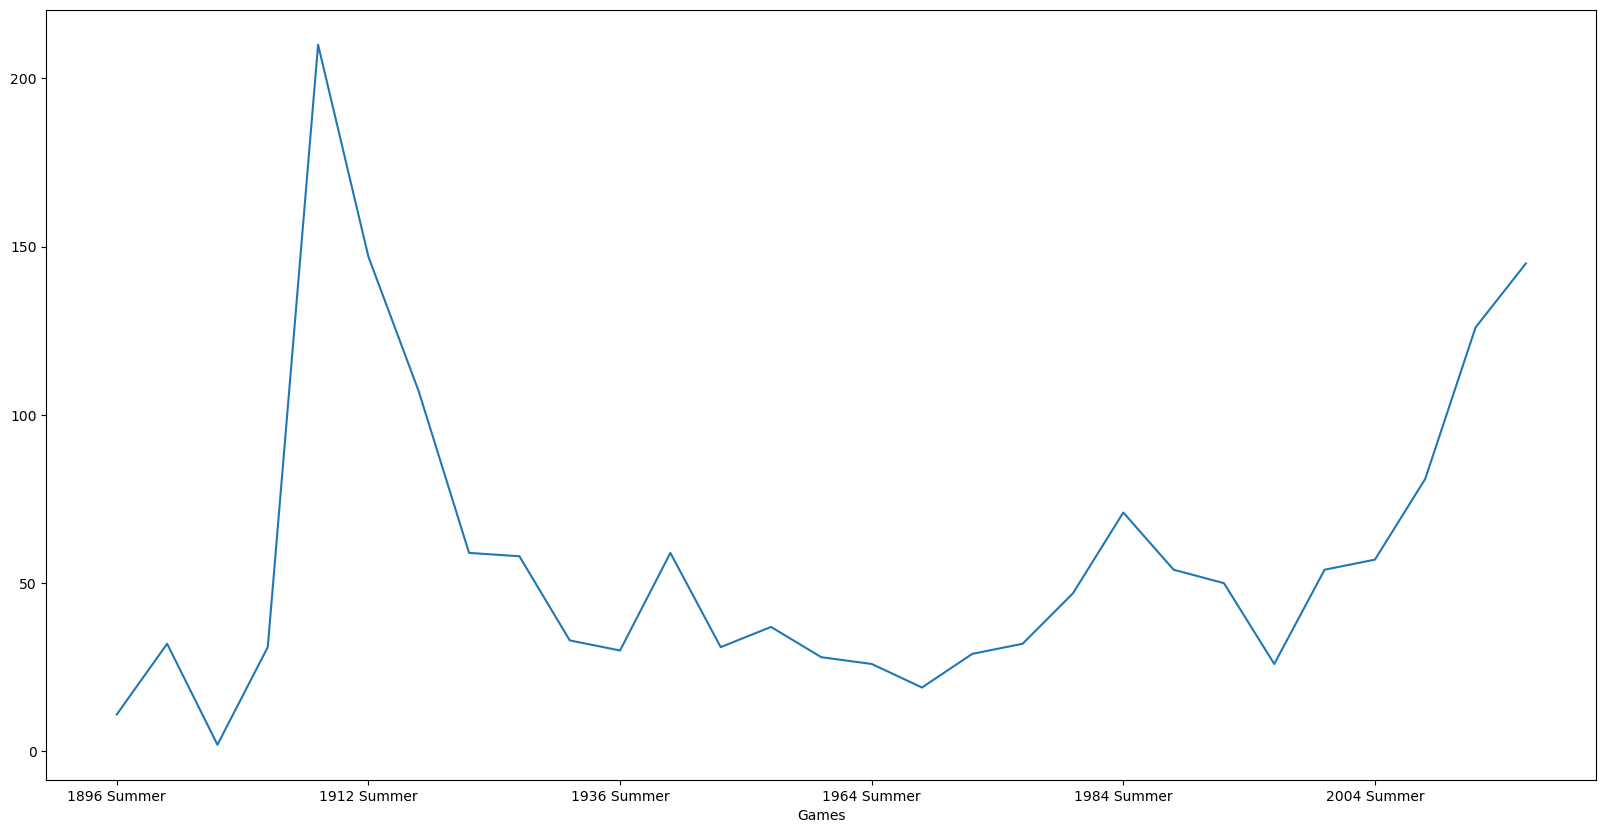

In [14]:
# Use a line chart to plot the medal count for the English team in the Summer Olympics.
games_df_gb['total_medals'].plot(kind='line', figsize=(20, 10))

In [15]:
# Calculate the average medal count for the English team for the summer olympics
average_medal_count_gb = games_df_gb['total_medals'].mean()
print(average_medal_count_gb)

# Calculate the average medal count for the Chinese team in the games where they won at least one medal
average_medal_count_gb_won = games_df_gb[games_df_gb['total_medals'] > 0]['total_medals'].mean()
print(average_medal_count_gb_won)

58.3448275862069
58.3448275862069


In [16]:
# Show the medal count for the 2012 Summer Games
games_df_gb.loc['2012 Summer']

Medal                       126.000000
gold_medals                  48.000000
silver_medals                30.000000
bronze_medals                48.000000
total_medals                126.000000
non_medal_participations    558.000000
total_participations        684.000000
medal_rate                    0.184211
gold_percentage               0.380952
silver_percentage             0.238095
bronze_percentage             0.380952
non_medal_percentage          0.815789
Name: 2012 Summer, dtype: float64

In [17]:
# add z_scores column to the games_df_gb dataframe
games_df_gb['z_scores'] = zscore(games_df_gb['total_medals'])
games_df_gb

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage,z_scores
Games,,,,,,,,,,,,,
1896 Summer,11,4,3,4,11,16,27,0.407407,0.363636,0.272727,0.363636,0.592593,-1.025196
1900 Summer,32,11,8,13,32,34,66,0.484848,0.343750,0.250000,0.406250,0.515152,-0.570466
1904 Summer,2,1,1,0,2,4,6,0.333333,0.500000,0.500000,0.000000,0.666667,-1.220080
1906 Summer,31,9,14,8,31,73,104,0.298077,0.290323,0.451613,0.258065,0.701923,-0.592120
1908 Summer,210,92,72,46,210,591,801,0.262172,0.438095,0.342857,0.219048,0.737828,3.283912
1912 Summer,147,38,50,59,147,263,410,0.358537,0.258503,0.340136,0.401361,0.641463,1.919722
1920 Summer,107,48,42,17,107,232,339,0.315634,0.448598,0.392523,0.158879,0.684366,1.053570
1924 Summer,59,15,25,19,59,364,423,0.139480,0.254237,0.423729,0.322034,0.860520,0.014187
1928 Summer,58,7,27,24,58,290,348,0.166667,0.120690,0.465517,0.413793,0.833333,-0.007467


In [19]:
# Calculate the mean total_medals for the English team in all Games except for UK 2012
mean_total_medals_gb = games_df_gb[games_df_gb.index != '2012 Summer']['total_medals'].mean()
print(mean_total_medals_gb)

# Calculate the z-score of the total_medals for the Chinese team in all Games except for Beijing 2008
z_score_total_medals_gb = zscore(games_df_gb[games_df_gb.index != '2012 Summer']['total_medals'])
print(z_score_total_medals_gb)

57.535714285714285
Games
1896 Summer   -0.994432
1900 Summer   -0.545678
1904 Summer   -1.186755
1906 Summer   -0.567048
1908 Summer    3.258043
1912 Summer    1.911782
1920 Summer    1.057013
1924 Summer    0.031291
1928 Summer    0.009921
1932 Summer   -0.524309
1936 Summer   -0.588417
1948 Summer    0.031291
1952 Summer   -0.567048
1956 Summer   -0.438832
1960 Summer   -0.631155
1964 Summer   -0.673894
1968 Summer   -0.823478
1972 Summer   -0.609786
1976 Summer   -0.545678
1980 Summer   -0.225140
1984 Summer    0.287721
1988 Summer   -0.075555
1992 Summer   -0.161032
1996 Summer   -0.673894
2000 Summer   -0.075555
2004 Summer   -0.011448
2012 Summer    1.463028
2016 Summer    1.869044
Name: total_medals, dtype: float64


In [20]:
# Using our games_df_rw dataframe, let's get the 2008 Summer Games data
summer_2012_rw = games_df_rw[games_df_rw['Games'] == '2012 Summer']

# let's order this data by descending medal count
summer_2012_rw = summer_2012_rw.sort_values(by='Medal', ascending=False)

# let's only use the Games, NOC, and Medal columns
summer_2012_rw_short = summer_2012_rw[['Games', 'NOC', 'Medal']]
print('Great Britian 2012 Medal Count for the Rest of the World:')
summer_2012_rw_short.head()

Great Britian 2012 Medal Count for the Rest of the World:


,Games,NOC,Medal
2566,2012 Summer,USA,248
2528,2012 Summer,RUS,140
2409,2012 Summer,CHN,125
2381,2012 Summer,AUS,114
2442,2012 Summer,GER,94


In [21]:
# Let's calculate the average medal count for the rest of the world in the 2008 Summer Olympics
average_medal_count_rw_2012 = summer_2012_rw['Medal'].mean()
average_medal_count_rw_2012

8.897058823529411